# Global Average Pooling Layers for Object Localization

### Global Average Pooling ###
In the last few years, experts have turned to global average pooling (GAP) layers to minimize overfitting by reducing the total number of parameters in the model. Similar to max pooling layers, GAP layers are used to reduce the spatial dimensions of a three-dimensional tensor. However, GAP layers perform a more extreme type of dimensionality reduction, where a tensor with dimensions h×w×d is reduced in size to have dimensions 1×1×d. GAP layers reduce each h×w feature map to a single number by simply taking the average of all hw values.

The ResNet-50 model takes a less extreme approach; instead of getting rid of dense layers altogether, the GAP layer is followed by one densely connected layer with a softmax activation function that yields the predicted object classes.

### Object Localization ###
In mid-2016, researchers at MIT demonstrated that CNNs with GAP layers (a.k.a. GAP-CNNs) that have been trained for a classification task can also be used for object localization. That is, a GAP-CNN not only tells us what object is contained in the image - it also tells us where the object is in the image, and through no additional work on our part! The localization is expressed as a heat map (referred to as a class activation map), where the color-coding scheme identifies regions that are relatively important for the GAP-CNN to perform the object identification task.

The main idea is that each of the activation maps in the final layer preceding the GAP layer acts as a detector for a different pattern in the image, localized in space. To get the class activation map corresponding to an image, we need only to transform these detected patterns to detected objects.

This transformation is done by noticing each node in the GAP layer corresponds to a different activation map, and that the weights connecting the GAP layer to the final dense layer encode each activation map’s contribution to the predicted object class. To obtain the class activation map, we sum the contributions of each of the detected patterns in the activation maps, where detected patterns that are more important to the predicted object class are given more weight.

In [1]:
import numpy as np
import ast
import scipy
import matplotlib.pyplot as plt
import cv2
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing import image
from keras.models import Model
import sys

Using TensorFlow backend.


In [2]:
def pretrained_path_to_tensor(img_path):
    # load image as RGB
    img = image.load_img(img_path, target_size=(224,224))
    # convert to 3D tensor of shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert to 4D tensor of shape (1, 224, 224, 3)
    x = np.expand_dims(x, axis=0)
    # preprocess image for resnet50
    return preprocess_input(x)

In [3]:
def get_Resnet():
    # define Resnet model
    model = ResNet50(weights='imagenet')
    # get activation map(AMP) layer weights
    all_amp_layer_weights = model.layers[-1].get_weights()[0]
    # extract wanted output, [-4] for last convolution layer and [-1] for output vector
    Resnet_model = Model(inputs=model.input, outputs=(model.layers[-4].output, model.layers[-1].output))
    return Resnet_model, all_amp_layer_weights

In [4]:
def Resnet_CAM(img_path, model, all_amp_layer_weights):
    # get filtered images from convolution output + model prediction vector
    last_conv_output, pred_vec = model.predict(pretrained_path_to_tensor(img_path))
    # change dim from 1 x 7 x 7 x 2048 to 7 x 7 x 2048
    last_conv_output = np.squeeze(last_conv_output)
    # model prediction
    pred = np.argmax(pred_vec)
    # bilinear upsampling of filter map(class activation map) to resize image size
    upscale_filter = scipy.ndimage.zoom(last_conv_output, (32, 32, 1), order=1) # upscale_filter dim: 224 x 224 x 2048
    # get amp layer weights
    amp_layer = all_amp_layer_weights[:, pred]
    # get class activation map(CAM) for predicted object class
    f_output = np.dot(upscale_filter.reshape(224*224, 2048), amp_layer).reshape(224, 224)
    # return CAM with pred object 
    return f_output, pred

In [5]:
def plot_CAM(img_path, ax, model, all_amp_layer_weights):
    # load image
    im = cv2.resize(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB), (224, 224))
    # plot image
    ax.imshow(im, alpha=0.5)
    # get CAM
    CAM, pred = Resnet_CAM(img_path, model, all_amp_layer_weights)
    # plot CAM
    ax.imshow(CAM, cmap='jet', alpha=0.5)
    # laod object detection dictionary
    with open('imagenet1000_clsid_to_human.txt') as f:
        image_dict = ast.literal_eval(f.read())
    # obtain predicted image net category
    ax.set_title(image_dict[pred])

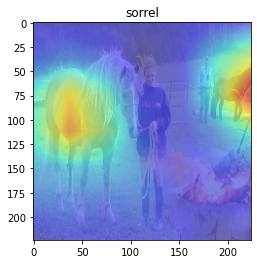

In [6]:
if __name__ == "__main__":
    ResNet_model, all_amp_layer_weights = get_Resnet()
    img_path = './dataset/10815824_2997e03d76.jpg'# sys.argv[1]
    fig, ax = plt.subplots()
    CAM = plot_CAM(img_path, ax, ResNet_model, all_amp_layer_weights)
    plt.show()

Reference: https://alexisbcook.github.io/2017/global-average-pooling-layers-for-object-localization/